# The Hybrid Montecarlo Algorithm

In [103]:
import numpy as np
import matplotlib.pyplot as plt

In [104]:
%config InlineBackend.figure_format = "retina"
np.seterr(divide='ignore', invalid='ignore')
plt.rcParams["figure.figsize"] = (9, 5)

## A primer on graphing ODEs with python

[Source](https://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html)

In [105]:
from scipy import integrate

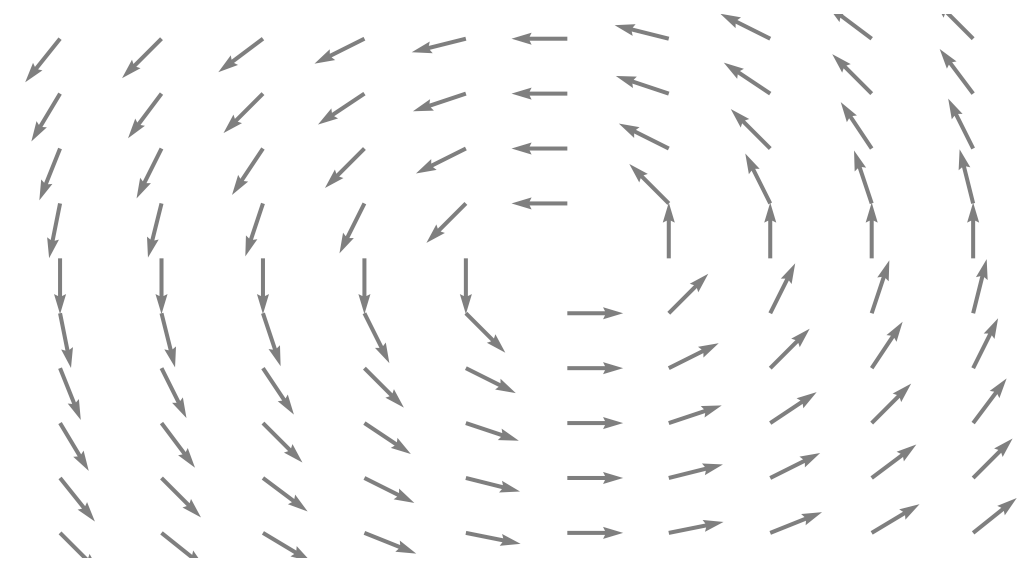

In [106]:
X, Y = np.mgrid[-5:5:1, -5:5:1]
U = - Y / np.sqrt(X ** 2 + Y ** 2)
V =   X / np.sqrt(X ** 2 + Y ** 2)

plt.quiver(X, Y, U, V, color="tab:gray", width=0.004)
plt.axis("off");

### The Lotka-Volterra Model

$$
\begin{align}
\frac{dx}{dt} &= \alpha x - \beta xy\\
\frac{dy}{dt} &= -\gamma y + \delta\beta x y
\end{align}
$$

In [107]:
alpha, beta = 1., 0.1
gamma, delta = 1.5, 0.75

def dX_dt(X, t=0):
    """
    Return growth rate of fox and rabbit populations
    """
    x, y = X
    growth_rate = np.array([
         alpha * x - beta * x * y,
        -gamma * y + delta * beta * x * y
    ])
    return growth_rate

In [108]:
t = np.linspace(0, 15, 1000)
# 10 prays / 5 predators
X0 = np.array([10, 5])
X, infodict = integrate.odeint(dX_dt, X0, t, full_output=True)

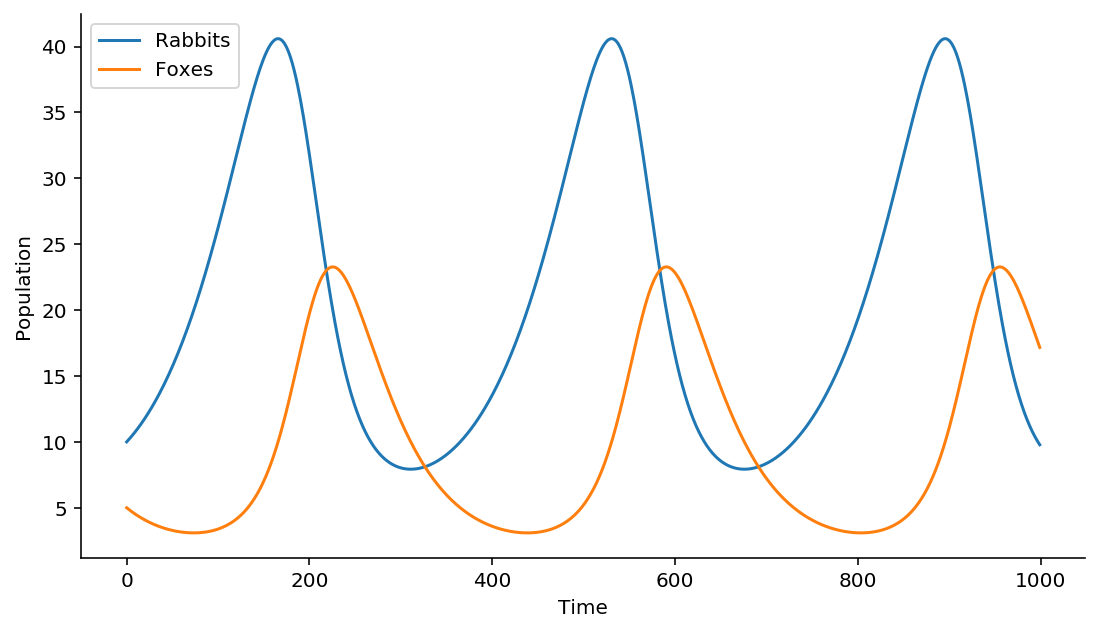

In [109]:
fig, ax = plt.subplots()
ax.plot(X)
ax.legend(["Rabbits", "Foxes"])
ax.set_ylabel("Population")
ax.set_xlabel("Time")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

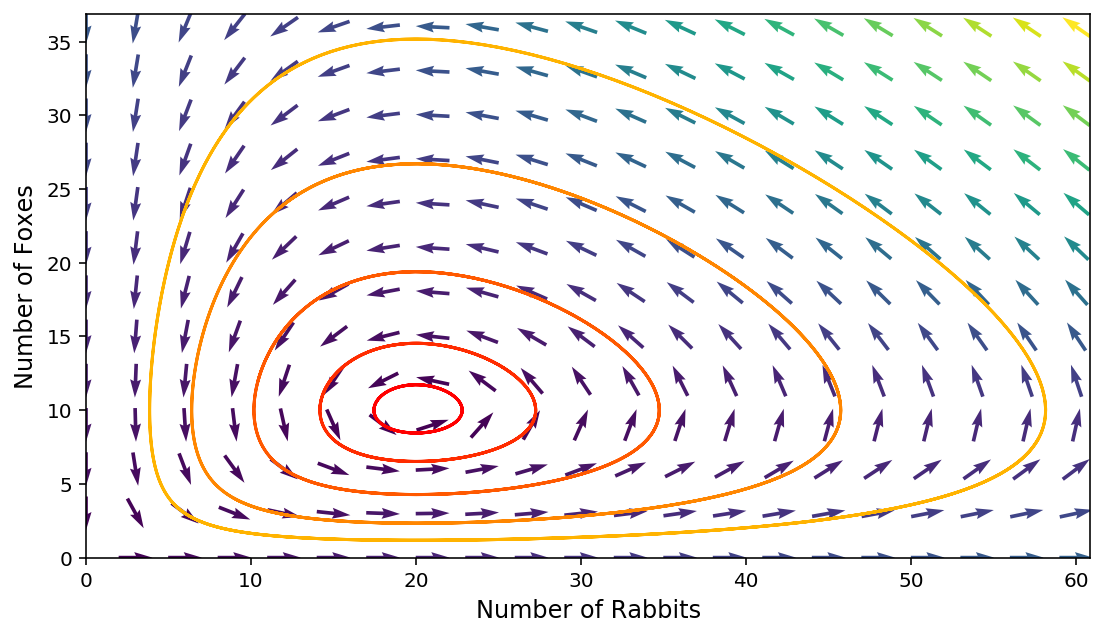

In [114]:
nvals = 5
values = np.linspace(0.3, 0.5, nvals)
vcolors = plt.cm.autumn_r(np.linspace(0.3, 1, nvals))

values = np.array([
    [6, 3],
    [9, 4],
    [12, 6],
    [15, 8],
    [18, 9]
])

for v, col in zip(values, vcolors):
    X0 = v 
    X = integrate.odeint(dX_dt, X0, t)
    plt.plot(*X.T, color=col)
    
ymax = plt.ylim(ymin=0)[1]
xmax = plt.xlim(xmin=0)[1]


step = 3
S = np.mgrid[0:xmax:step, 0:ymax:step]
DS = dX_dt(S)
M = np.hypot(*DS)
DS /= M
    
plt.quiver(*S, *DS, M, pivot="mid")
plt.xlabel("Number of Rabbits", fontsize=12)
plt.ylabel("Number of Foxes", fontsize=12);